# 연습문제 
다항선형회귀분석으로 재현하고, 설명력과 에러율을 표시하라 (표준화 적용x )
훈련데이터와 검정데이터에 대한 관측치와 예측치에 대한 시각화를 제시하라

In [156]:
import os, sys
sys.path.append("../../")
from helper import myOls, scalling, getBestFeatures, ml_ols

from pca import pca
from pandas import read_excel, DataFrame, merge, melt
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


In [157]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## 문제 1

아래의 데이터는 콩의 수분 함유량에 따른 강도를 조사한 데이터이다.

In [209]:
df = read_excel("https://data.hossam.kr/E04/beans.xlsx")
df

,수분함유량,강도
0,36,29
1,40,32
2,34,29
3,44,40
4,33,31
5,36,29
6,40,34
7,33,30
8,26,25
9,36,31


In [159]:
# 데이터 전처리 
poly = PolynomialFeatures(degree=2, include_bias=True)
fit = poly.fit_transform(df[['수분함유량']])
fit

array([[1.000e+00, 3.600e+01, 1.296e+03],
       [1.000e+00, 4.000e+01, 1.600e+03],
       [1.000e+00, 3.400e+01, 1.156e+03],
       [1.000e+00, 4.400e+01, 1.936e+03],
       [1.000e+00, 3.300e+01, 1.089e+03],
       [1.000e+00, 3.600e+01, 1.296e+03],
       [1.000e+00, 4.000e+01, 1.600e+03],
       [1.000e+00, 3.300e+01, 1.089e+03],
       [1.000e+00, 2.600e+01, 6.760e+02],
       [1.000e+00, 3.600e+01, 1.296e+03]])

`PolynomialFeatures`클래스를 사용하여 $y = ax + b$ 라는 회귀식을 $y = ax^2 + bx + c$ 형태로 바꾼다.

In [160]:
# 생성된 피처의 이름 확인
poly.get_feature_names_out()

array(['1', '수분함유량', '수분함유량^2'], dtype=object)

In [161]:
# 2차식 변경
poly = PolynomialFeatures(include_bias=False)
fit = poly.fit_transform(df[['수분함유량']])
fit

array([[  36., 1296.],
       [  40., 1600.],
       [  34., 1156.],
       [  44., 1936.],
       [  33., 1089.],
       [  36., 1296.],
       [  40., 1600.],
       [  33., 1089.],
       [  26.,  676.],
       [  36., 1296.]])

In [162]:
poly.get_feature_names_out() # 생성된 피처의 이름 확인

array(['수분함유량', '수분함유량^2'], dtype=object)

In [163]:
# 데이터 프레임으로 재구성
x = DataFrame(fit, columns=poly.get_feature_names_out())
x.head()

,수분함유량,수분함유량^2
0,36.0,1296.0
1,40.0,1600.0
2,34.0,1156.0
3,44.0,1936.0
4,33.0,1089.0


In [164]:
# 종속변수만 추출
y = df[['강도']]
y.head()

,강도
0,29
1,32
2,29
3,40
4,31


In [165]:
# 테스트 데이터와 검증 데이터로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7, 2), (3, 2), (7, 1), (3, 1))

In [166]:
# 깨알같은 표본수지만 회귀분석을 수행함

model = LinearRegression()
fit = model.fit(x_train, y_train)

print("계수: ", fit.coef_)
print("절편: ", fit.intercept_)
print("훈련 데이터 설명력: ", fit.score(x_train, y_train))
print("검증 데이터 설명력: ", fit.score(x_test, y_test))

계수:  [[-2.05422407  0.04045876]]
절편:  [51.29936854]
훈련 데이터 설명력:  0.948987598169573
검증 데이터 설명력:  -8.143084034528927


In [167]:
# 회귀식을 추정함
feature_names = x.columns
#print(feature_names)

expr = []
for i, v in enumerate(feature_names):
    expr.append("%f x %s" % (fit.coef_[0][i], v))
    
expr = " + ".join(expr)
expr = "y = " + expr + " + %f" % fit.intercept_[0]
expr

'y = -2.054224 x 수분함유량 + 0.040459 x 수분함유량^2 + 51.299369'

예측값 생성

In [168]:
# 훈련 데이터에 대한 예측값 
y_train_pred = fit.predict(x_train)
y_train_pred = y_train_pred.reshape(-1)
y_train_pred

array([29.78185993, 25.23966705, 39.24167623, 33.86442786, 33.86442786,
       29.78185993, 28.22608113])

In [169]:
# 검증 데이터에 대한 예측값 
y_test_pred = fit.predict(x_test)
y_test_pred = y_test_pred.reshape(-1)
y_test_pred

array([27.56956803, 29.78185993, 27.56956803])

#### 시각화

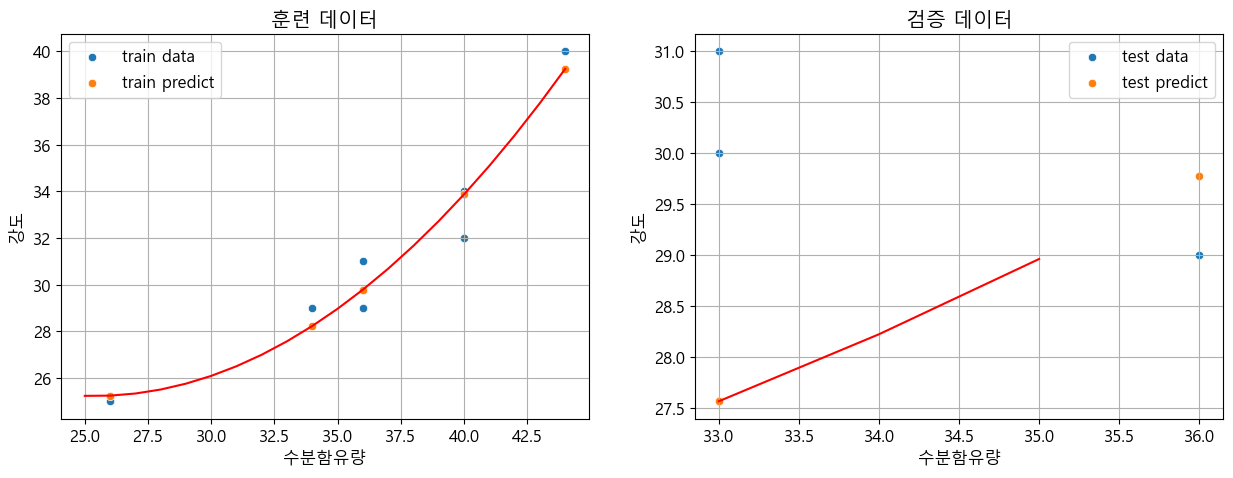

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 학습에 사용한 데이터와 예측값의 차이를 시각화
sb.scatterplot(x=x_train['수분함유량'], y=y_train['강도'], label='train data', ax=ax1)
sb.scatterplot(x=x_train['수분함유량'], y=y_train_pred, label='train predict', ax=ax1)

# 그래프가 그려진 범위 안에서 1씩 증가하는 좌표를 생성
xmin, xmax = ax1.get_xlim()
xrange = np.arange(xmin.round(), xmax.round(), 1)
# y값에 대한 추정치를 계산
y_pred = xrange * fit.coef_[0][0] + xrange**2 * fit.coef_[0][1] + fit.intercept_[0]

# 추세선
sb.lineplot(x=xrange, y=y_pred, color='red', ax=ax1)

ax1.set_title("훈련 데이터")
ax1.legend()
ax1.grid()


# 검증용 데이터와 예측값의 차이를 시각화
sb.scatterplot(x=x_test['수분함유량'], y=y_test['강도'], label='test data', ax=ax2)
sb.scatterplot(x=x_test['수분함유량'], y=y_test_pred, label='test predict', ax=ax2)

# 그래프가 그려진 범위 안에서 1씩 증가하는 좌표를 생성
xmin, xmax = ax2.get_xlim()
xrange = np.arange(xmin.round(), xmax.round(), 1)

# y값에 대한 추정치를 계산
y_pred = xrange * fit.coef_[0][0] + xrange**2 * fit.coef_[0][1] + fit.intercept_[0]

# 추세선
sb.lineplot(x=xrange, y=y_pred, color='red', ax=ax2)

ax2.set_title("검증 데이터")
ax2.legend()
ax2.grid()

plt.show()
plt.close()

In [173]:
# 설명력
olsResult = ml_ols(df, xnames='수분함유량', yname='강도', degree=2, test_size=0.3, random_state=123)

print('계수 :',olsResult.coef)
print('절편 :',olsResult.intercept)

계수 : [[-2.05422407  0.04045876]]
절편 : [51.29936854]


In [174]:
# 에러율 - 훈련데이터
print('R^2 :',olsResult.trainRegMetric.r2)
print('MAE :',olsResult.trainRegMetric.mae)
print('MSE :',olsResult.trainRegMetric.mse)
print('RMSE :',olsResult.trainRegMetric.rmse)
print('MAPE :',olsResult.trainRegMetric.mape)
print('MPE :',olsResult.trainRegMetric.mpe)

R^2 : 0.948987598169573
MAE : 0.8245585260510643
MSE : 0.9744409819036656
RMSE : 0.9871377725037501
MAPE : 2.624827833276785
MPE : -0.08405044961718751


In [175]:
# 에러율 - 검증데이터
print('R^2 :',olsResult.testRegMetric.r2)
print('MAE :',olsResult.testRegMetric.mae)
print('MSE :',olsResult.testRegMetric.mse)
print('RMSE :',olsResult.testRegMetric.rmse)
print('MAPE :',olsResult.testRegMetric.mape)
print('MPE :',olsResult.testRegMetric.mpe)

R^2 : -8.143084034528927
MAE : 2.214241293532337
MSE : 6.0953893563526185
RMSE : 2.4688842330803236
MAPE : 7.287806079908203
MPE : 5.490426927922782


## 문제 2

아래의 데이터는 10년간 에어컨의 예약대수에 따른 실 판매대수를 조사한 가상의 데이터이다.

In [176]:
df = read_excel("https://data.hossam.kr/E04/aircon.xlsx")
df.head()

,예약대수,판매대수
0,19,33
1,23,51
2,26,40
3,29,49
4,30,50


In [179]:
# 데이터 전처리 
poly = PolynomialFeatures(degree=2, include_bias=True)
fit = poly.fit_transform(df[['예약대수']])
fit

array([[1.000e+00, 1.900e+01, 3.610e+02],
       [1.000e+00, 2.300e+01, 5.290e+02],
       [1.000e+00, 2.600e+01, 6.760e+02],
       [1.000e+00, 2.900e+01, 8.410e+02],
       [1.000e+00, 3.000e+01, 9.000e+02],
       [1.000e+00, 3.800e+01, 1.444e+03],
       [1.000e+00, 3.900e+01, 1.521e+03],
       [1.000e+00, 4.600e+01, 2.116e+03],
       [1.000e+00, 4.900e+01, 2.401e+03],
       [1.000e+00, 5.800e+01, 3.364e+03]])

In [180]:
# 2차식 변경
poly = PolynomialFeatures(include_bias=False)
fit = poly.fit_transform(df[['예약대수']])
fit

array([[  19.,  361.],
       [  23.,  529.],
       [  26.,  676.],
       [  29.,  841.],
       [  30.,  900.],
       [  38., 1444.],
       [  39., 1521.],
       [  46., 2116.],
       [  49., 2401.],
       [  58., 3364.]])

In [181]:
# 데이터 프레임으로 재구성
x = DataFrame(fit, columns=poly.get_feature_names_out())
x.head()

,예약대수,예약대수^2
0,19.0,361.0
1,23.0,529.0
2,26.0,676.0
3,29.0,841.0
4,30.0,900.0


In [182]:
# 종속변수만 추출
y = df[['판매대수']]
y.head()

,판매대수
0,33
1,51
2,40
3,49
4,50


In [183]:
# 테스트 데이터와 검증 데이터로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7, 2), (3, 2), (7, 1), (3, 1))

In [184]:
# 깨알같은 표본수지만 회귀분석을 수행함

model = LinearRegression()
fit = model.fit(x_train, y_train)

print("계수: ", fit.coef_)
print("절편: ", fit.intercept_)
print("훈련 데이터 설명력: ", fit.score(x_train, y_train))
print("검증 데이터 설명력: ", fit.score(x_test, y_test))

계수:  [[ 1.72732907e+00 -1.10258345e-03]]
절편:  [3.61731765]
훈련 데이터 설명력:  0.9418315846138151
검증 데이터 설명력:  0.3583742568809699


In [185]:
# 회귀식을 추정함
feature_names = x.columns
#print(feature_names)

expr = []
for i, v in enumerate(feature_names):
    expr.append("%f x %s" % (fit.coef_[0][i], v))
    
expr = " + ".join(expr)
expr = "y = " + expr + " + %f" % fit.intercept_[0]
expr

'y = 1.727329 x 예약대수 + -0.001103 x 예약대수^2 + 3.617318'

In [186]:
# 훈련 데이터에 대한 예측값 
y_train_pred = fit.predict(x_train)
y_train_pred = y_train_pred.reshape(-1)
y_train_pred

array([ 67.66369172,  85.6091391 ,  52.78258793,  42.76261956,
        69.30612186, 100.09331284,  47.782527  ])

In [187]:
# 검증 데이터에 대한 예측값 
y_test_pred = fit.predict(x_test)
y_test_pred = y_test_pred.reshape(-1)
y_test_pred

array([54.44486457, 36.03853731, 80.74138818])

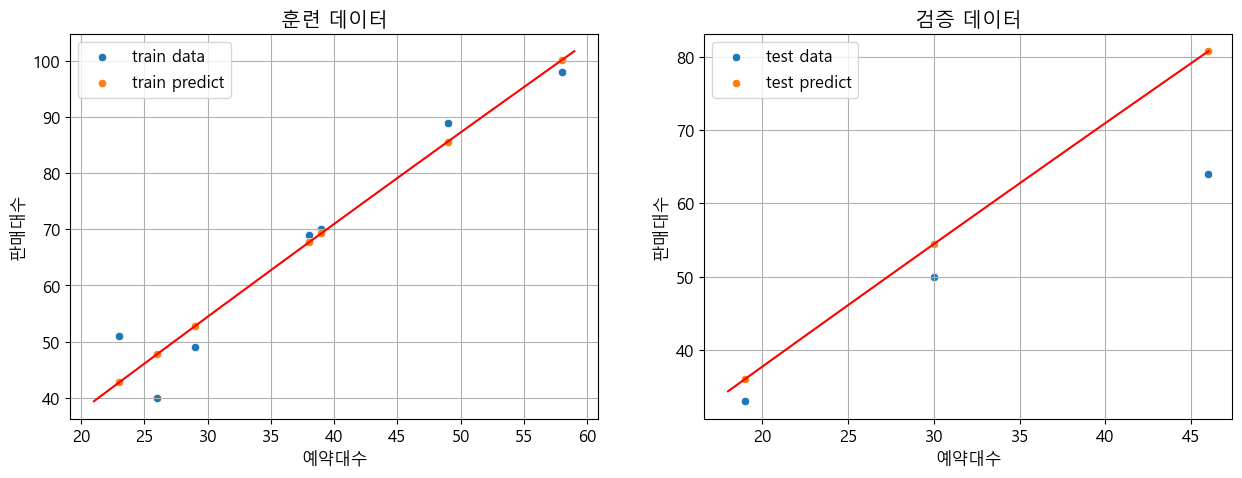

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 학습에 사용한 데이터와 예측값의 차이를 시각화
sb.scatterplot(x=x_train['예약대수'], y=y_train['판매대수'], label='train data', ax=ax1)
sb.scatterplot(x=x_train['예약대수'], y=y_train_pred, label='train predict', ax=ax1)

# 그래프가 그려진 범위 안에서 1씩 증가하는 좌표를 생성
xmin, xmax = ax1.get_xlim()
xrange = np.arange(xmin.round(), xmax.round(), 1)
# y값에 대한 추정치를 계산
y_pred = xrange * fit.coef_[0][0] + xrange**2 * fit.coef_[0][1] + fit.intercept_[0]

# 추세선
sb.lineplot(x=xrange, y=y_pred, color='red', ax=ax1)

ax1.set_title("훈련 데이터")
ax1.legend()
ax1.grid()


# 검증용 데이터와 예측값의 차이를 시각화
sb.scatterplot(x=x_test['예약대수'], y=y_test['판매대수'], label='test data', ax=ax2)
sb.scatterplot(x=x_test['예약대수'], y=y_test_pred, label='test predict', ax=ax2)

# 그래프가 그려진 범위 안에서 1씩 증가하는 좌표를 생성
xmin, xmax = ax2.get_xlim()
xrange = np.arange(xmin.round(), xmax.round(), 1)

# y값에 대한 추정치를 계산
y_pred = xrange * fit.coef_[0][0] + xrange**2 * fit.coef_[0][1] + fit.intercept_[0]

# 추세선
sb.lineplot(x=xrange, y=y_pred, color='red', ax=ax2)

ax2.set_title("검증 데이터")
ax2.legend()
ax2.grid()

plt.show()
plt.close()

In [192]:
# 설명력
olsResult = ml_ols(df, xnames='예약대수', yname='판매대수', degree=2, test_size=0.3, random_state=123)

print('계수 :',olsResult.coef)
print('절편 :',olsResult.intercept)

계수 : [[ 1.72732907e+00 -1.10258345e-03]]
절편 : [3.61731765]


In [190]:
# 에러율 - 훈련데이터
print('R^2 :',olsResult.trainRegMetric.r2)
print('MAE :',olsResult.trainRegMetric.mae)
print('MSE :',olsResult.trainRegMetric.mse)
print('RMSE :',olsResult.trainRegMetric.rmse)
print('MAPE :',olsResult.trainRegMetric.mape)
print('MPE :',olsResult.trainRegMetric.mpe)

R^2 : 0.948987598169573
MAE : 0.8245585260510643
MSE : 0.9744409819036656
RMSE : 0.9871377725037501
MAPE : 2.624827833276785
MPE : -0.08405044961718751


In [191]:
# 에러율 - 검증데이터
print('R^2 :',olsResult.testRegMetric.r2)
print('MAE :',olsResult.testRegMetric.mae)
print('MSE :',olsResult.testRegMetric.mse)
print('RMSE :',olsResult.testRegMetric.rmse)
print('MAPE :',olsResult.testRegMetric.mape)
print('MPE :',olsResult.testRegMetric.mpe)

R^2 : -8.143084034528927
MAE : 2.214241293532337
MSE : 6.0953893563526185
RMSE : 2.4688842330803236
MAPE : 7.287806079908203
MPE : 5.490426927922782


## 문제3

아래의 데이터는 부모의 키에 따른 자식의 키를 조사한 데이터이다.

In [194]:
df = read_excel("https://data.hossam.kr/E04/galton.xlsx")
df

,child,parent
0,61.7,70.5
1,61.7,68.5
2,61.7,65.5
3,61.7,64.5
4,61.7,64.0
...,...,...
923,73.7,69.5
924,73.7,69.5
925,73.7,69.5
926,73.7,69.5


In [195]:
# 데이터 전처리 
poly = PolynomialFeatures(degree=2, include_bias=True)
fit = poly.fit_transform(df[['parent']])
fit

array([[1.00000e+00, 7.05000e+01, 4.97025e+03],
       [1.00000e+00, 6.85000e+01, 4.69225e+03],
       [1.00000e+00, 6.55000e+01, 4.29025e+03],
       ...,
       [1.00000e+00, 6.95000e+01, 4.83025e+03],
       [1.00000e+00, 6.95000e+01, 4.83025e+03],
       [1.00000e+00, 6.95000e+01, 4.83025e+03]])

In [196]:
# 2차식 변경
poly = PolynomialFeatures(include_bias=False)
fit = poly.fit_transform(df[['parent']])
fit

array([[  70.5 , 4970.25],
       [  68.5 , 4692.25],
       [  65.5 , 4290.25],
       ...,
       [  69.5 , 4830.25],
       [  69.5 , 4830.25],
       [  69.5 , 4830.25]])

In [197]:
# 데이터 프레임으로 재구성
x = DataFrame(fit, columns=poly.get_feature_names_out())
x.head()

,parent,parent^2
0,70.5,4970.25
1,68.5,4692.25
2,65.5,4290.25
3,64.5,4160.25
4,64.0,4096.00


In [198]:
# 종속변수만 추출
y = df[['child']]
y.head()

,child
0,61.7
1,61.7
2,61.7
3,61.7
4,61.7


In [199]:
# 테스트 데이터와 검증 데이터로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((649, 2), (279, 2), (649, 1), (279, 1))

In [200]:
model = LinearRegression()
fit = model.fit(x_train, y_train)

print("계수: ", fit.coef_)
print("절편: ", fit.intercept_)
print("훈련 데이터 설명력: ", fit.score(x_train, y_train))
print("검증 데이터 설명력: ", fit.score(x_test, y_test))

계수:  [[-6.14018278  0.04983418]]
절편:  [254.8071062]
훈련 데이터 설명력:  0.21158873072593132
검증 데이터 설명력:  0.21619722340979886


In [201]:
# 회귀식을 추정함
feature_names = x.columns
#print(feature_names)

expr = []
for i, v in enumerate(feature_names):
    expr.append("%f x %s" % (fit.coef_[0][i], v))
    
expr = " + ".join(expr)
expr = "y = " + expr + " + %f" % fit.intercept_[0]
expr

'y = -6.140183 x parent + 0.049834 x parent^2 + 254.807106'

In [203]:
# 훈련 데이터에 대한 예측값 
y_train_pred = fit.predict(x_train)
y_train_pred = y_train_pred.reshape(-1)
# 검증 데이터에 대한 예측값 
y_test_pred = fit.predict(x_test)
y_test_pred = y_test_pred.reshape(-1)

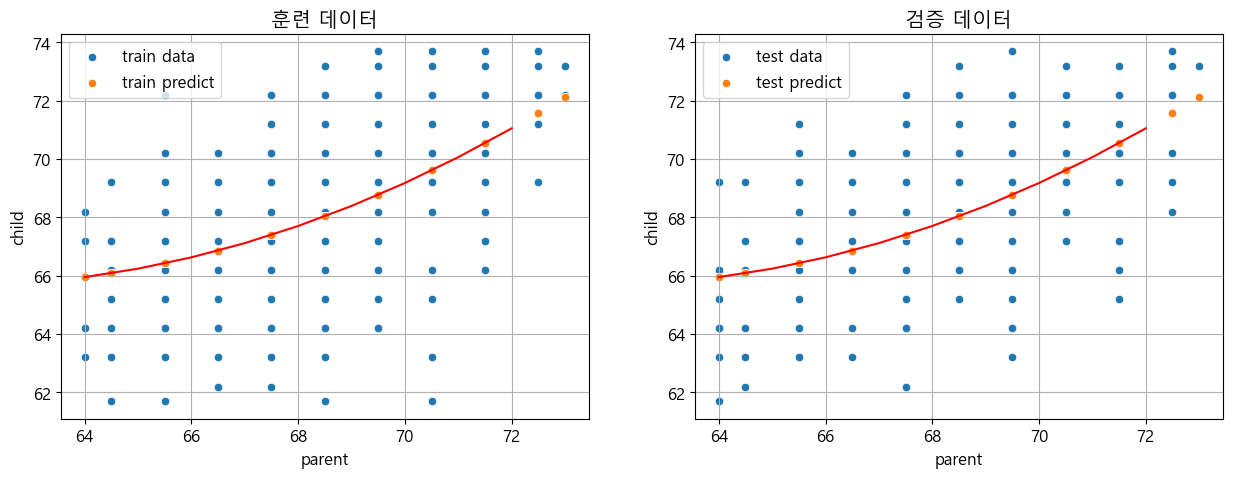

In [205]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 학습에 사용한 데이터와 예측값의 차이를 시각화
sb.scatterplot(x=x_train['parent'], y=y_train['child'], label='train data', ax=ax1)
sb.scatterplot(x=x_train['parent'], y=y_train_pred, label='train predict', ax=ax1)

# 그래프가 그려진 범위 안에서 1씩 증가하는 좌표를 생성
xmin, xmax = ax1.get_xlim()
xrange = np.arange(xmin.round(), xmax.round(), 1)
# y값에 대한 추정치를 계산
y_pred = xrange * fit.coef_[0][0] + xrange**2 * fit.coef_[0][1] + fit.intercept_[0]

# 추세선
sb.lineplot(x=xrange, y=y_pred, color='red', ax=ax1)

ax1.set_title("훈련 데이터")
ax1.legend()
ax1.grid()


# 검증용 데이터와 예측값의 차이를 시각화
sb.scatterplot(x=x_test['parent'], y=y_test['child'], label='test data', ax=ax2)
sb.scatterplot(x=x_test['parent'], y=y_test_pred, label='test predict', ax=ax2)

# 그래프가 그려진 범위 안에서 1씩 증가하는 좌표를 생성
xmin, xmax = ax2.get_xlim()
xrange = np.arange(xmin.round(), xmax.round(), 1)

# y값에 대한 추정치를 계산
y_pred = xrange * fit.coef_[0][0] + xrange**2 * fit.coef_[0][1] + fit.intercept_[0]

# 추세선
sb.lineplot(x=xrange, y=y_pred, color='red', ax=ax2)

ax2.set_title("검증 데이터")
ax2.legend()
ax2.grid()

plt.show()
plt.close()

In [206]:
# 에러율 - 훈련데이터
print('R^2 :',olsResult.trainRegMetric.r2)
print('MAE :',olsResult.trainRegMetric.mae)
print('MSE :',olsResult.trainRegMetric.mse)
print('RMSE :',olsResult.trainRegMetric.rmse)
print('MAPE :',olsResult.trainRegMetric.mape)
print('MPE :',olsResult.trainRegMetric.mpe)

R^2 : 0.9418315846138151
MAE : 3.902407933472026
MSE : 22.982459630133462
RMSE : 4.794002464552293
MAPE : 7.457361969614873
MPE : -0.9174718034904255


In [207]:
# 에러율 - 검증데이터
print('R^2 :',olsResult.testRegMetric.r2)
print('MAE :',olsResult.testRegMetric.mae)
print('MSE :',olsResult.testRegMetric.mse)
print('RMSE :',olsResult.testRegMetric.rmse)
print('MAPE :',olsResult.testRegMetric.mape)
print('MPE :',olsResult.testRegMetric.mpe)

R^2 : 0.3583742568809699
MAE : 8.074930020670541
MSE : 103.08786939445751
RMSE : 10.153219656564982
MAPE : 14.751945665039626
MPE : -14.751945665039626


## 2. 연습문제
1. 다항선형회귀 분석을 수행하라
2. 범주형 변수가 있다면 통제요인으로 설정하여 더미 변수로 추가하라
3. 훈련데이터와 검정데이터에 대한 관측치와 예측치에 대한 시각화를 제시하라

In [ ]:
# 다음의 데이터는 442명의 당뇨병 환자를 대상으로 검사 결과이다.
# 표준화가 되어 있다. 

In [208]:
df = read_excel("https://data.hossam.kr/E04/diabetes.xlsx")
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220


In [ ]:
# 데이터 전처리 
poly = PolynomialFeatures(degree=2, include_bias=True)
fit = poly.fit_transform(df[['수분함유량']])
fit

In [ ]:
### 데이터 표준화
#### 독립변수에 대한 표준화
x_train = df.drop(['target'], axis=1)
x_train_std = StandardScaler().fit_transform(x_train)
x_train_std_df = DataFrame(x_train_std, columns=x_train.columns)
x_train_std_df

In [ ]:
# 종속변수에 대한 표준화
y_train = df.filter(['target'], axis=1)
y_train_std = StandardScaler().fit_transform(y_train)
y_train_std_df = DataFrame(y_train_std, columns=y_train.columns)
y_train_std_df

In [ ]:
# 전체 요인에 대한 회귀분석
mdf = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
xnames = list(x_train_std_df.columns)
model1 = myOls(mdf, y='target', x=xnames)
model1.summary

In [ ]:
# 결과표
model1.table

In [ ]:
# PCA 분석
pca_model = pca()
fit = pca_model.fit_transform(x_train_std_df)
topfit = fit['topfeat']
topfit

In [ ]:
# 선정된 요인 이름 추출
best = topfit.query("type=='best'")
feature = list(set(list(best['feature'])))

# 선정된 요인을 사용하여 회귀분석 수행
mdf = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
model2 = myOls(mdf, y='target', x=feature)
model2.summary

In [ ]:
### 두 가지 모델의 결과 비교

#### 결과 비교를 위한 데이터프레임 생성

rdf = DataFrame({
    's6': mdf['s6'],
    'y': mdf['target'],
    'y1': model1.fit.predict(x_train_std_df),
    'y2': model2.fit.predict(x_train_std_df)
})
rdf

In [ ]:
# 실제 값과 model1의 예측 결과를 재배치
mdf1 = melt(rdf, id_vars=['s6'], value_vars=['y', 'y1'])
mdf1

In [ ]:
# 실제 값과 model2의 예측 결과 재배치
mdf2 = melt(rdf, id_vars=['s6'], value_vars=['y', 'y2'])
mdf2

In [ ]:
# 재배치 결과 시각화
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["axes.unicode_minus"] = False

sb.lmplot(data=mdf1, x="s6", y="value", hue="variable", height=5, aspect=3)
sb.lmplot(data=mdf2, x="s6", y="value", hue="variable", height=5, aspect=3)

plt.show()
plt.close()

## 연습문제 2 

다음의 데이터 뉴욕 멘하튼의 주택임대료에 영향을 준다고 예상되는 변수들과 주택 임대료를 정리한 것이다.

다양한 변수 중에서 목표로 하는 종속변수는 rent이다. 분석하라

In [ ]:
df = read_excel("https://data.hossam.kr/E04/manhattan.xlsx")
df

In [ ]:
### 데이터 전처리
# 불필요한 변수 제거
df2 = df.drop(['neighborhood', 'borough'], axis=1)
df2.head()

In [ ]:
# 표준화 
x_train_std_df, y_train_std_df = scalling(df2, 'rent') 

In [ ]:
# 주 성분 분석
feature, topfeat_df = getBestFeatures(x_train_std_df)
topfeat_df

In [ ]:
mdf = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
ols_result = myOls(mdf, y='rent', x=feature)
ols_result.summary

In [ ]:
# 실제 임대료와 예측된 임대료 비교
rdf = DataFrame({
    'x': mdf['building_age_yrs'],
    'rent': mdf['rent'],
    'y': ols_result.fit.predict(x_train_std_df)
})

rdf

In [ ]:
melt_df = melt(rdf, id_vars=['x'], value_vars=['rent','y'])
melt_df

In [ ]:
sb.lmplot(data=melt_df, x="x", y="value", hue="variable", height=7, aspect=3)
plt.show()
plt.close()